In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

class MachineLearning:
    
    def CompareClassifiers(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if n == 2:
            methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                       SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
        else:
            methods = [KNeighborsClassifier(), MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            clf = methods[i].fit(X_train, y_train)
            train_acc.append(clf.score(X_train, y_train))
            test_acc.append(clf.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def CompareRegressors(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
        strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            reg = methods[i].fit(X_train, y_train)
            train_acc.append(reg.score(X_train, y_train))
            test_acc.append(reg.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, X, y, metric='accuracy'):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    def PipeIt(self, scaler, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
        return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))


class DataHelper:
    
    def ScaleData(self, strategy, y_var, data):
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
        selector = SelectKBest(k=k).fit(X, y)
        mask = selector.get_support()
        selected = []
        for i in range(len(mask)):
            if mask[i] == True:
                selected.append(X.columns[i])
        df = pd.DataFrame(selector.transform(X))
        df.columns = selected
        return df
    
    def VifIt(self, X):
        vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
        return vif
        
    
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma'):
        try:
            cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap)
            return cm
        except:
            return 'Please fit model before passing'
    
    def BuildTree(self, tree):
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            model.fit(X_train, y_train)
            return 'coefficients: {}'.format(model.coef_)
        except:
            return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        try:
            FI = model.feature_importances_
            n_features = X_train.shape[1]
            plt.figure(figsize=(8,8))
            plt.barh(range(n_features), FI, align='center') 
            plt.yticks(np.arange(n_features), X_train.columns.values) 
            plt.xlabel('Feature importance')
            plt.ylabel('Feature')
        except:
            return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
        pred = model.predict(Xval)
        fpr, tpr, threshold = roc_curve(yval, pred)
        return auc(fpr, tpr)
    
ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()

In [2]:
df = pd.read_csv(r'C:\Users\aacjp\OneDrive\Desktop\data\tables\ChurnData_ForML.csv')

HO = dh.HoldOut(df)
df = HO[0].drop(['Unnamed: 0'], axis='columns')
val_df = HO[1].drop(['Unnamed: 0'], axis='columns')

In [3]:
X = df.drop(['churn'], axis='columns')
y = df['churn']
ml.CompareClassifiers(X, y)

C:\Users\aacjp\Anaconda3\envs\flatiron-env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,train_acc,test_acc
0,KNN,0.902179,0.876000
1,NB,0.872388,0.880000
2,DT,1.000000,0.922667
3,RF,1.000000,0.949333
4,AB,0.899511,0.886667
5,GB,0.978657,0.940000
6,XGB,0.973766,0.941333
7,Log,0.862161,0.856000
8,SVM,0.859048,0.853333


In [4]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y, metric='recall')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    4.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished


In [5]:
clf

XGBClassifier(max_depth=6, subsample=0.5)

In [6]:
ev.ScoreModel(clf, X, y)

'Training: 0.9835482436638506, Validation: 0.96'

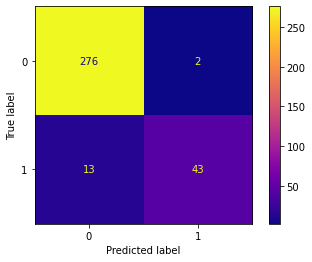

In [7]:
fitted_model = clf.fit(X, y)
Xval = val_df.drop(['churn'], axis='columns')
yval = val_df['churn']
ev.BuildConfusion(clf, Xval, yval)

In [9]:
ev.AUC(clf, Xval, yval)

0.8803314491264131

# Step 2...

normalize the data

Accuracy imporved more from MinMaxScaling but validation recall and AUC dropped significantly. I ended up using standard scaler instead.

In [10]:
scaler = StandardScaler()
ml.PipeIt(scaler, clf, X, y)

'Training: 0.9835482436638506, Validation: 0.9586666666666667'

In [11]:
scaler = MinMaxScaler()
ml.PipeIt(scaler, clf, X, y)

'Training: 0.9848821698532682, Validation: 0.952'

In [12]:
X = StandardScaler().fit(X).transform(X)
Xval = StandardScaler().fit(Xval).transform(Xval)
ml.CompareClassifiers(X, y)

,Model,train_acc,test_acc
0,KNN,0.907070,0.873333
1,NB,0.860827,0.870667
2,DT,1.000000,0.902667
3,RF,1.000000,0.956000
4,AB,0.897288,0.869333
5,GB,0.975545,0.950667
6,XGB,0.970654,0.948000
7,Log,0.872388,0.857333
8,SVM,0.945754,0.918667


In [13]:
parameters =  {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished


XGBClassifier(max_depth=6, subsample=0.7)

In [14]:
ev.ScoreModel(clf, X, y)

'Training: 0.9902178746109382, Validation: 0.944'

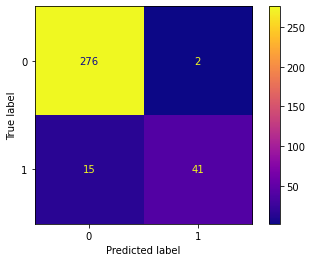

In [15]:
model = clf.fit(X, y)
ev.BuildConfusion(model, Xval, yval)

In [17]:
ev.AUC(clf, Xval, yval)

0.8624743062692704

In [18]:
'''
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}'''

"\nparam_grid = {\n    'learning_rate': [0.1, 0.2],\n    'max_depth': [6],\n    'min_child_weight': [1, 2],\n    'subsample': [0.5, 0.7],\n    'n_estimators': [100],\n}"

In [19]:
X3 = pd.DataFrame(SMOTE().fit_resample(X, y)[0])
y3 = SMOTE().fit_resample(X, y)[1]
df3 = pd.concat([X3, y3], axis='columns')
df3 = dh.HoldOut(df3)[0]
val3 = dh.HoldOut(df3)[1]

In [20]:
X = df3.drop(['churn'], axis='columns')
Xval = val3.drop(['churn'], axis='columns')
y = df3['churn']
yval = val3['churn']
ml.CompareClassifiers(X, y)

,Model,train_acc,test_acc
0,KNN,0.927398,0.887737
1,NB,0.736675,0.719344
2,DT,1.000000,0.936097
3,RF,1.000000,0.961140
4,AB,0.897724,0.887737
5,GB,0.962259,0.948187
6,XGB,0.959090,0.955959
7,Log,0.788245,0.812608
8,SVM,0.927687,0.910190


In [21]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.8s finished


XGBClassifier(learning_rate=0.2, max_depth=6, subsample=0.7)

In [22]:
ev.ScoreModel(clf, X, y)

'Training: 1.0, Validation: 0.968048359240069'

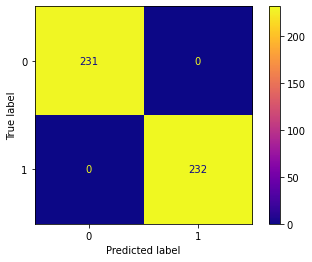

In [23]:
fitted = clf.fit(X, y)
ev.BuildConfusion(fitted, Xval, yval)

In [24]:
232 / 232

1.0

In [25]:
ev.AUC(clf, Xval, yval)

1.0

In [26]:
lst = ['international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 '%night',
 '%eve',
 'avg duration',
 'Midwest',
 'Noncontinental',
 'Northeast',
 'Northwest',
 'Southeast',
 'Southwest']

X.columns = lst
X.head()

,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,customer service calls,%night,%eve,avg duration,Midwest,Noncontinental,Northeast,Northwest,Southeast,Southwest
1718,-0.322166,-0.620660,-0.593572,1.208814,-0.684420,1.208318,1.052964,-0.856416,1.053268,0.759262,...,-1.173558,0.308169,-0.224580,-1.654297,-0.566697,-0.181849,1.672185,-0.352824,-0.56567,-0.348627
4061,3.103990,1.611187,1.469347,1.303861,0.164288,1.303611,1.003366,-1.365657,1.003371,-0.299685,...,-0.179268,0.470133,-1.290161,-1.168823,1.764612,-0.181849,-0.598020,-0.352824,-0.56567,-0.348627
1935,-0.322166,1.611187,1.887434,-1.393921,-0.033603,-1.393871,0.700437,-1.108225,0.701438,1.099491,...,0.335662,0.490493,-0.954281,-0.571459,-0.566697,-0.181849,1.672185,-0.352824,-0.56567,-0.348627
5025,-0.322166,-0.620660,-0.593572,-0.494493,0.868873,-0.494281,-0.885306,0.700734,-0.884426,1.371058,...,2.415908,-0.194446,0.046607,0.532689,0.000469,-0.181849,1.119884,-0.352824,-0.56567,-0.348627
1115,-0.322166,-0.620660,-0.593572,1.004642,0.016459,1.004904,-0.014519,1.057326,-0.013872,0.719700,...,0.335662,-0.785774,1.052398,-0.630471,1.764612,-0.181849,-0.598020,-0.352824,-0.56567,-0.348627


## Time for some Feature Engineering

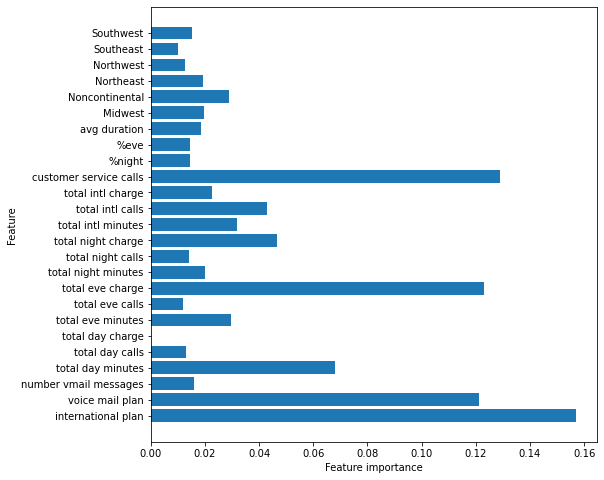

In [27]:
ev.GetImportance(clf, X, y)

In [32]:
Xval.columns = list(X.columns)

In [33]:
sample1 = X.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sv1 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages'], axis='columns')
sample2 = X.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sv2 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest'], axis='columns')
sample3 = X.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')
sv3 = Xval.drop(['Southwest', 'Southeast', 'Northwest', 'Northeast', 'Noncontinental', 'Midwest', '%eve', '%night', 'number vmail messages',
                 'total night charge', 'total night calls', 'total eve charge', 'total eve calls', 'total day charge', 'total day calls'], axis='columns')
sample4 = dh.MakeNewDF(X, y, 10)
sv4 = dh.MakeNewDF(Xval, yval, 10)
sample5 = dh.MakeNewDF(X, y, 19)
sv5 = dh.MakeNewDF(Xval, yval, 19)

In [34]:
ml.CompareClassifiers(sample1, y)

,Model,train_acc,test_acc
0,KNN,0.937482,0.886874
1,NB,0.791415,0.784974
2,DT,1.000000,0.929188
3,RF,1.000000,0.950777
4,AB,0.889369,0.890328
5,GB,0.967156,0.960276
6,XGB,0.963411,0.955959
7,Log,0.786517,0.797064
8,SVM,0.918755,0.913644


In [35]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample1, y)
clf

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.6s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)

AUC: 0.9978448275862069
Training: 1.0, Validation: 0.9645941278065631


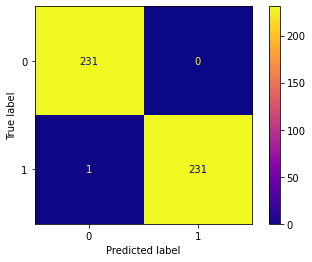

In [44]:
score = ev.ScoreModel(clf, sample1, y)
fit = clf.fit(sample1, y)
ev.BuildConfusion(fit, sv1, yval)
print('AUC: {}'.format(ev.AUC(clf, sv1, yval)))
print(score)

In [30]:
ml.CompareClassifiers(sample2, y)

,Model,train_acc,test_acc
0,KNN,0.928241,0.889853
1,NB,0.784144,0.769297
2,DT,1.000000,0.918474
3,RF,1.000000,0.960971
4,AB,0.895833,0.895924
5,GB,0.962963,0.949696
6,XGB,0.961227,0.948829
7,Log,0.790220,0.791847
8,SVM,0.912326,0.904597


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.5s finished


AUC: 0.9870503060158233
Training: 1.0, Validation: 0.9438687392055267


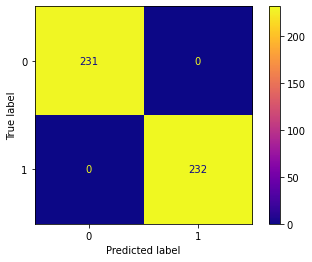

In [50]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(RandomForestClassifier(), parameters, sample2, y)
score = ev.ScoreModel(clf, sample2, y)
AUC = ev.AUC(clf, sv2, yval)
fit = clf.fit(sample2, y)
ev.BuildConfusion(fit, sv2, yval)
print('AUC: {}'.format(AUC))
print(score)

In [31]:
ml.CompareClassifiers(sample3, y)

,Model,train_acc,test_acc
0,KNN,0.932581,0.889853
1,NB,0.794271,0.810928
2,DT,1.000000,0.913270
3,RF,1.000000,0.953166
4,AB,0.894387,0.905464
5,GB,0.964410,0.950564
6,XGB,0.962095,0.957502
7,Log,0.774595,0.787511
8,SVM,0.912326,0.905464


In [51]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, sample3, y)
clf

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished


XGBClassifier(learning_rate=0.2, max_depth=6, subsample=0.7)

Training: 0.9988475943532124, Validation: 0.959412780656304


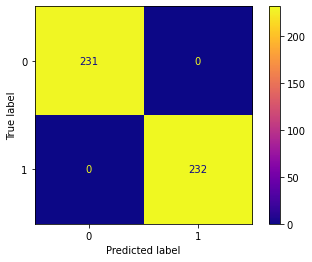

In [72]:
score = ev.ScoreModel(clf, sample3, y)
#auc = ev.AUC(clf, sample3, y)
fit = clf.fit(sv3, yval)
print(score)
#print('AUC: {}'.format(auc))
ev.BuildConfusion(fit, sv3, yval)

In [73]:
ml.CompareClassifiers(sample4, y)

,Model,train_acc,test_acc
0,KNN,0.917891,0.877375
1,NB,0.789398,0.791019
2,DT,1.000000,0.901554
3,RF,1.000000,0.926598
4,AB,0.890233,0.877375
5,GB,0.952175,0.927461
6,XGB,0.948718,0.922280
7,Log,0.768943,0.784111
8,SVM,0.891386,0.871330


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.4s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)
Training: 0.9962546816479401, Validation: 0.9404145077720207


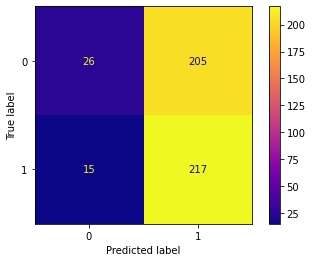

In [74]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample4, y)
print(clf)
score = ev.ScoreModel(clf, sample4, y)
print(score)
fit = clf.fit(sample4, y)
#auc = ev.AUC(clf, sample4, y)
#print('AUC: {}'.format(auc))
ev.BuildConfusion(fit, sv4, yval)

In [77]:
ml.CompareClassifiers(sample5, y)

,Model,train_acc,test_acc
0,KNN,0.929991,0.886874
1,NB,0.740421,0.740933
2,DT,1.000000,0.916235
3,RF,1.000000,0.943005
4,AB,0.894843,0.904145
5,GB,0.959954,0.940415
6,XGB,0.955632,0.936097
7,Log,0.782772,0.780656
8,SVM,0.920196,0.901554


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.6s finished


GradientBoostingClassifier(max_depth=5, n_estimators=200)
Training: 0.9997118985883031, Validation: 0.9732297063903281


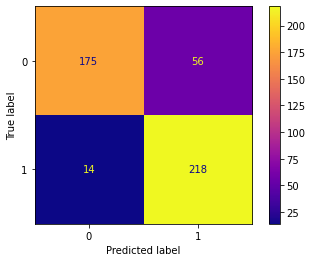

In [80]:
parameters = {'max_depth': [3, 5, None], 'n_estimators': [50, 100, 200]}
clf = ml.Optimize(GradientBoostingClassifier(), parameters, sample5, y)
print(clf)
score = ev.ScoreModel(clf, sample5, y)
print(score)
#auc = ev.AUC(clf, sv5, yval)
#print('AUC: {}'.format(auc))
fit = clf.fit(sample5, y)
ev.BuildConfusion(fit, sv5, yval)

In [83]:
sample3.to_csv('Churn3.csv')